c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading data from C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv...
Initial data shape: (2898, 16)
Columns: ['Month', 'Grade', 'Region', 'Is_Active_Region', 'Regional_Price', 'National_Price', 'Seasonal_Impact', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (2898, 46)
Unique grades: ['alba' 'c4' 'c5' 'c5sp' 'h1' 'h2' 'h_faq']
Unique regions: ['colombo' 'galle' 'hambantota' 'kalutara' 'matara' 'ratnapura']

Data loaded successfully!
Shape: (2898, 46)

First few rows:


<Figure size 1400x800 with 0 Axes>

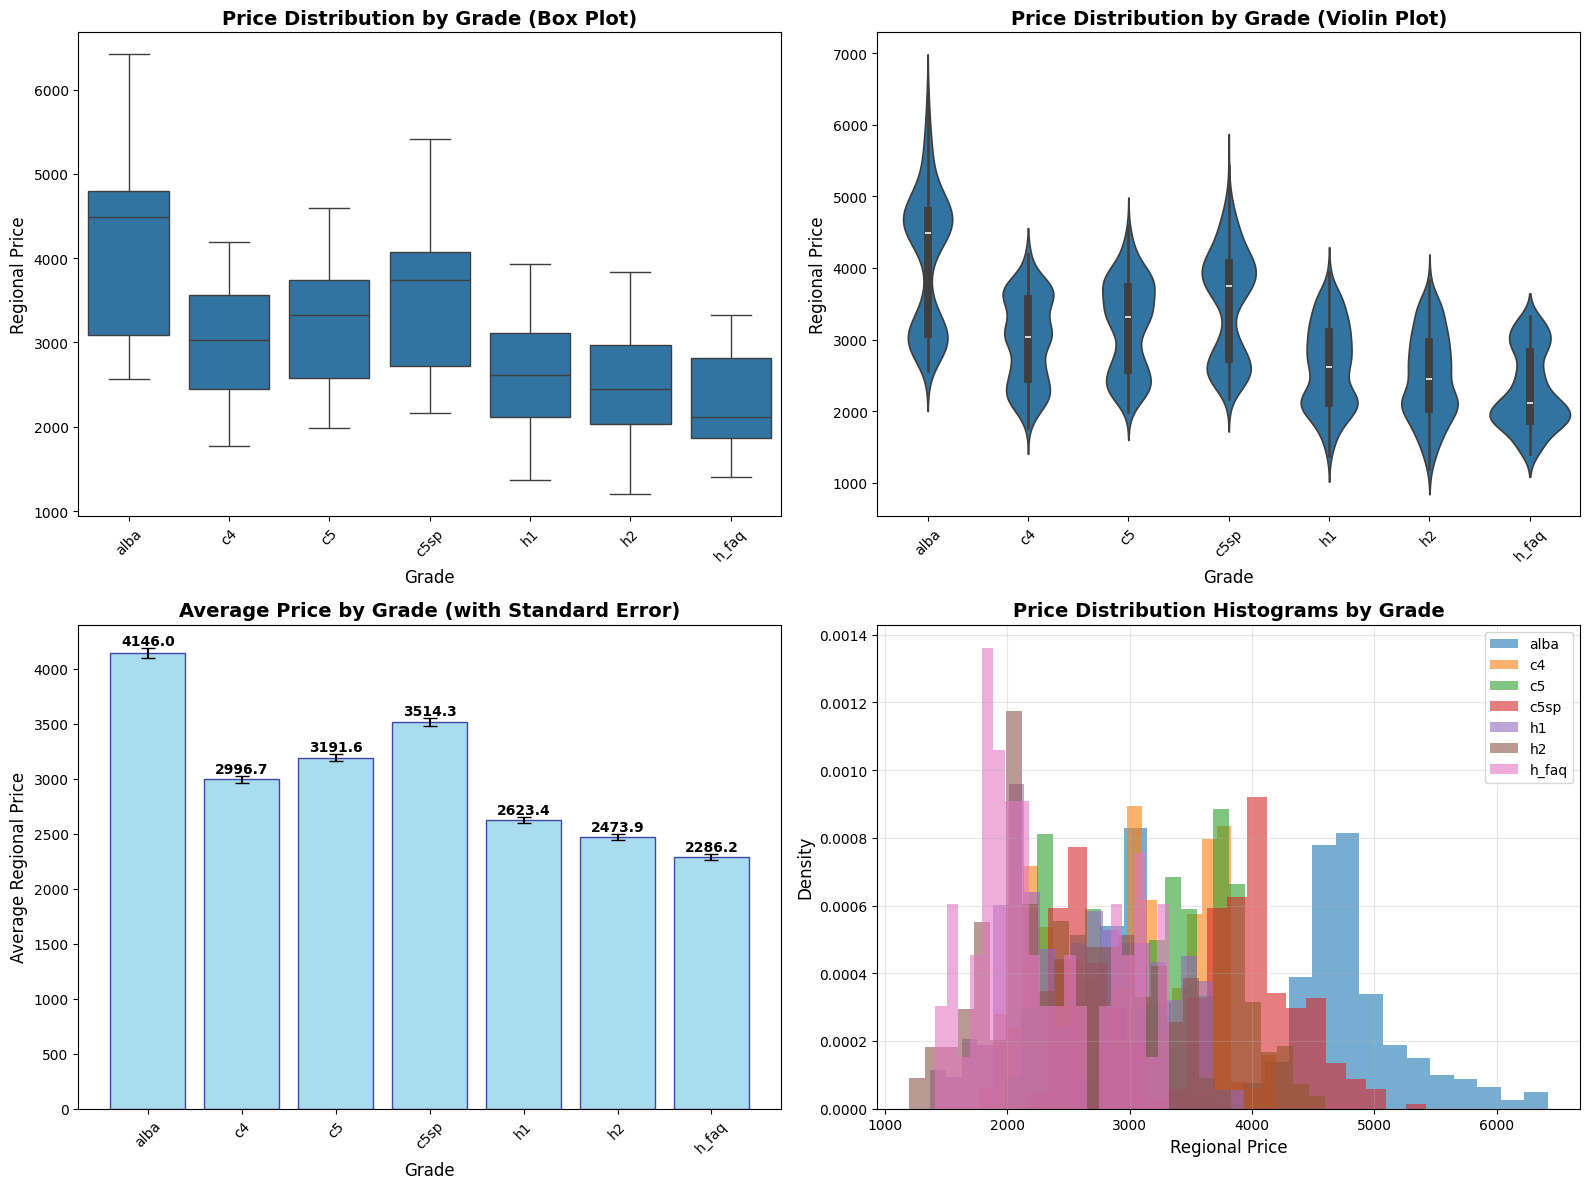


Price Distribution Summary by Grade:
       count     mean     std      min      25%      50%      75%      max
Grade                                                                     
alba   414.0  4145.98  938.87  2566.50  3083.25  4492.50  4793.75  6420.00
c4     414.0  2996.70  602.69  1766.25  2452.50  3033.22  3560.94  4197.00
c5     414.0  3191.63  639.77  1983.00  2578.50  3321.20  3736.88  4600.00
c5sp   414.0  3514.34  750.05  2166.75  2723.47  3743.88  4070.00  5419.80
h1     414.0  2623.44  589.65  1368.75  2116.54  2615.62  3109.38  3937.50
h2     414.0  2473.92  596.50  1199.75  2031.77  2450.00  2965.63  3831.25
h_faq  414.0  2286.17  537.07  1407.50  1865.00  2120.00  2821.00  3324.50


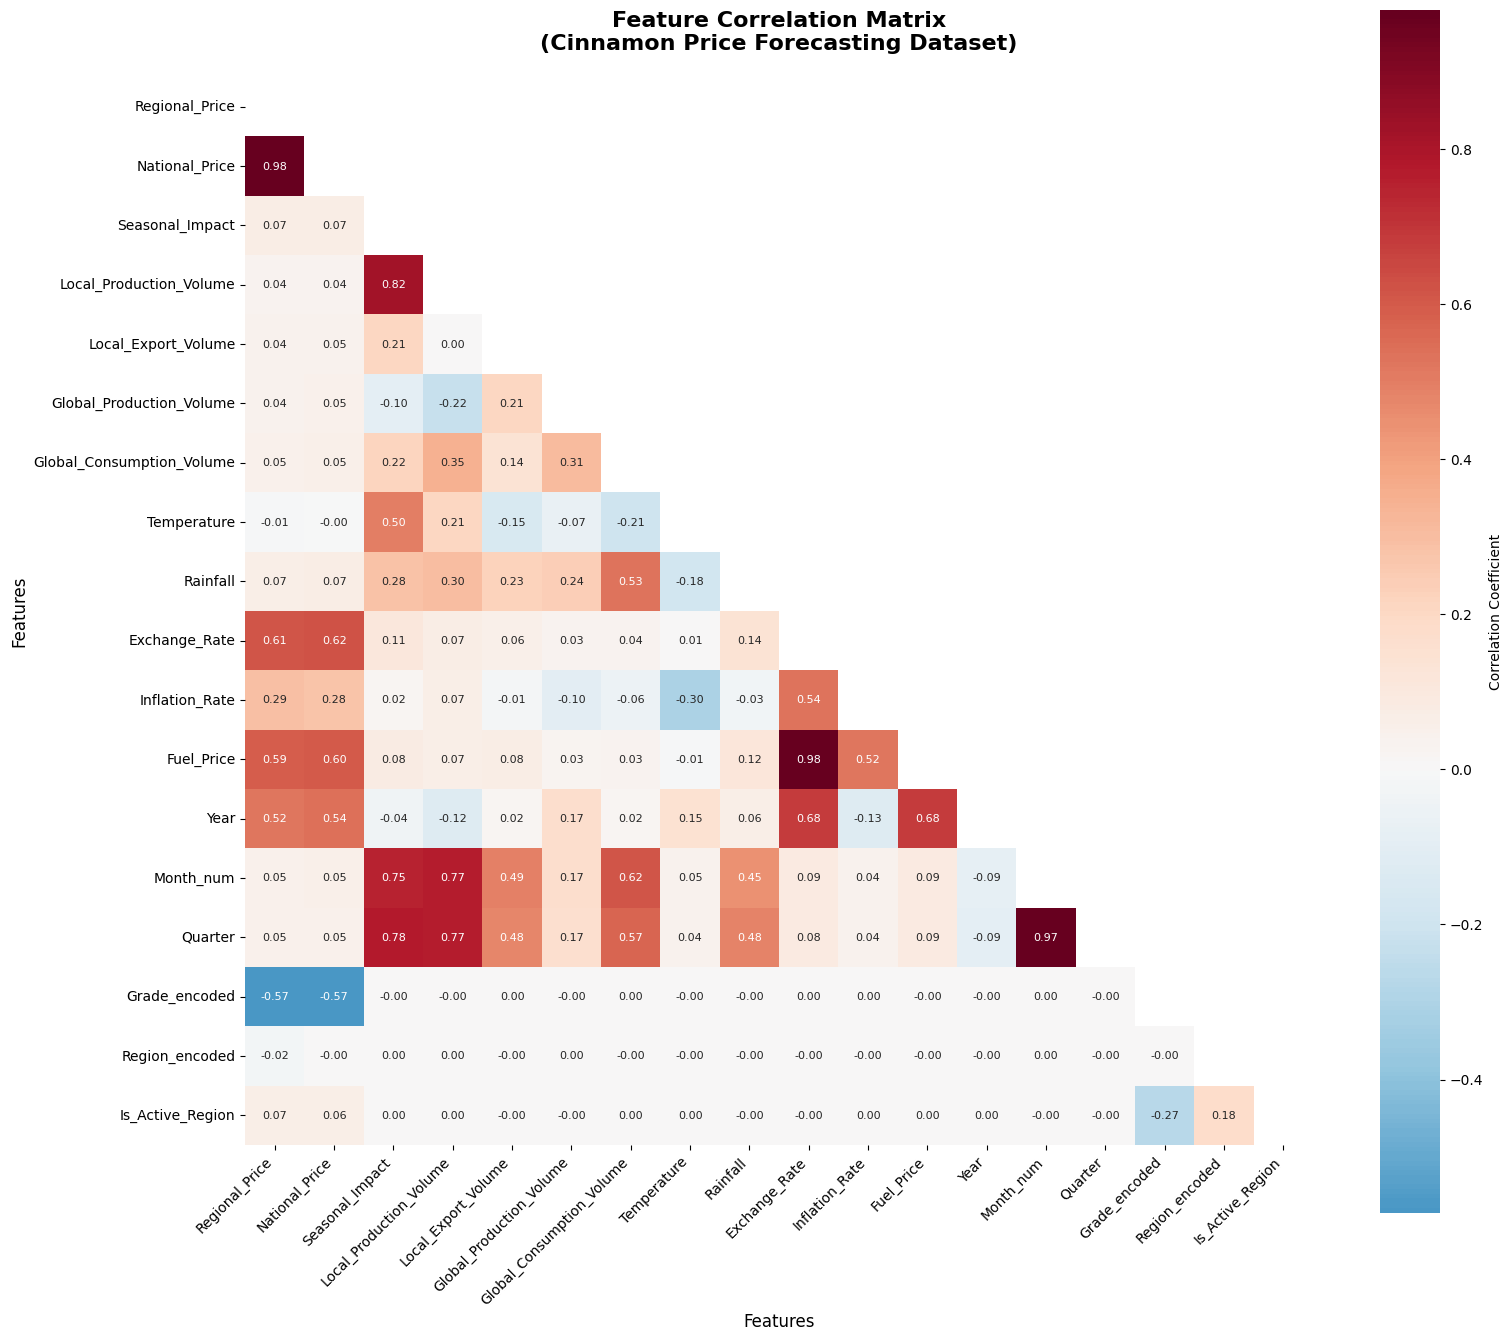


Highly Correlated Feature Pairs (|correlation| > 0.7):
Exchange_Rate ↔ Fuel_Price: 0.980
Regional_Price ↔ National_Price: 0.978
Month_num ↔ Quarter: 0.971
Seasonal_Impact ↔ Local_Production_Volume: 0.818
Seasonal_Impact ↔ Quarter: 0.776
Local_Production_Volume ↔ Quarter: 0.771
Local_Production_Volume ↔ Month_num: 0.767
Seasonal_Impact ↔ Month_num: 0.753

🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING
Preparing sequences...


[I 2025-09-23 15:41:25,244] A new study created in memory with name: no-name-f02a917f-1408-4d17-827f-e55fe44dcfb6


Total sequences created: 2394
Created 2394 sequences with shape (2394, 12, 42)
Scaling features...
Training set shape: X=(1436, 12, 42), y=(1436,)
Validation set shape: X=(479, 12, 42), y=(479,)
Test set shape: X=(479, 12, 42), y=(479,)

🔧 Performing hyperparameter tuning using optuna method...

🚀 Starting Hyperparameter Tuning using OPTUNA method...

🎯 Starting Optuna Hyperparameter Tuning...


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.0611187:   1%|          | 1/100 [01:54<3:09:21, 114.77s/it]

[I 2025-09-23 15:43:19,992] Trial 0 finished with value: 0.06111868843436241 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0001425181802434827, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.06111868843436241.


Best trial: 1. Best value: 0.0311879:   2%|▏         | 2/100 [03:18<2:37:17, 96.30s/it] 

[I 2025-09-23 15:44:43,382] Trial 1 finished with value: 0.03118785098195076 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.0007627183754609682, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 1 with value: 0.03118785098195076.


Best trial: 1. Best value: 0.0311879:   3%|▎         | 3/100 [04:30<2:17:47, 85.23s/it]

[I 2025-09-23 15:45:55,436] Trial 2 finished with value: 0.03269748389720917 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.5, 'dense_units': 16, 'learning_rate': 0.002234389441346433, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.03118785098195076.


Best trial: 3. Best value: 0.0275951:   4%|▍         | 4/100 [05:24<1:56:45, 72.97s/it]

[I 2025-09-23 15:46:49,599] Trial 3 finished with value: 0.027595121413469315 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0032604335742399543, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.027595121413469315.


Best trial: 3. Best value: 0.0275951:   5%|▌         | 5/100 [07:41<2:31:57, 95.97s/it]

[I 2025-09-23 15:49:06,343] Trial 4 finished with value: 0.10439616441726685 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 32, 'learning_rate': 0.00010709312220055451, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 3 with value: 0.027595121413469315.


Best trial: 3. Best value: 0.0275951:   6%|▌         | 6/100 [09:06<2:24:38, 92.33s/it]

[I 2025-09-23 15:50:31,630] Trial 5 finished with value: 0.07328984141349792 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.00016530846038818788, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.027595121413469315.


Best trial: 6. Best value: 0.0266491:   7%|▋         | 7/100 [10:16<2:11:52, 85.08s/it]

[I 2025-09-23 15:51:41,771] Trial 6 finished with value: 0.026649057865142822 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0006905884002165239, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:   8%|▊         | 8/100 [11:23<2:01:32, 79.27s/it]

[I 2025-09-23 15:52:48,586] Trial 7 finished with value: 0.032951660454273224 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.008177902967606555, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:   9%|▉         | 9/100 [12:21<1:50:21, 72.77s/it]

[I 2025-09-23 15:53:47,048] Trial 8 finished with value: 0.0612969808280468 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0010062594752942042, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:  10%|█         | 10/100 [14:52<2:25:19, 96.89s/it]

[I 2025-09-23 15:56:17,970] Trial 9 finished with value: 0.038161635398864746 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.007616966122965017, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:  11%|█         | 11/100 [16:09<2:14:40, 90.79s/it]

[I 2025-09-23 15:57:34,928] Trial 10 finished with value: 0.037987858057022095 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.00039442148937005706, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:  12%|█▏        | 12/100 [17:25<2:06:23, 86.18s/it]

[I 2025-09-23 15:58:50,556] Trial 11 finished with value: 0.02665897272527218 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0024535894722986515, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:  13%|█▎        | 13/100 [18:27<1:54:26, 78.92s/it]

[I 2025-09-23 15:59:52,801] Trial 12 finished with value: 0.02976909466087818 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.001919587364693445, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:  14%|█▍        | 14/100 [19:45<1:52:31, 78.50s/it]

[I 2025-09-23 16:01:10,313] Trial 13 finished with value: 0.0281778946518898 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0006075268246253928, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 6. Best value: 0.0266491:  15%|█▌        | 15/100 [20:44<1:43:02, 72.74s/it]

[I 2025-09-23 16:02:09,711] Trial 14 finished with value: 0.0402110330760479 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0002985487423023439, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 6 with value: 0.026649057865142822.


Best trial: 15. Best value: 0.0258698:  16%|█▌        | 16/100 [21:53<1:40:17, 71.64s/it]

[I 2025-09-23 16:03:18,807] Trial 15 finished with value: 0.025869818404316902 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0013276030728873074, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 15 with value: 0.025869818404316902.


Best trial: 15. Best value: 0.0258698:  17%|█▋        | 17/100 [22:59<1:36:46, 69.96s/it]

[I 2025-09-23 16:04:24,867] Trial 16 finished with value: 0.030639773234725 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.4, 'dense_units': 128, 'learning_rate': 0.0012632490966526936, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 15 with value: 0.025869818404316902.


Best trial: 15. Best value: 0.0258698:  18%|█▊        | 18/100 [24:22<1:40:49, 73.77s/it]

[I 2025-09-23 16:05:47,496] Trial 17 finished with value: 0.0289976354688406 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.000492739345837694, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 15 with value: 0.025869818404316902.


Best trial: 15. Best value: 0.0258698:  19%|█▉        | 19/100 [26:06<1:51:49, 82.83s/it]

[I 2025-09-23 16:07:31,440] Trial 18 finished with value: 0.045602668076753616 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.004130097311803781, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.025869818404316902.


Best trial: 15. Best value: 0.0258698:  20%|██        | 20/100 [27:16<1:45:36, 79.21s/it]

[I 2025-09-23 16:08:42,182] Trial 19 finished with value: 0.02721976675093174 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0013647526671761079, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 15 with value: 0.025869818404316902.


Best trial: 15. Best value: 0.0258698:  21%|██        | 21/100 [29:04<1:55:39, 87.84s/it]

[I 2025-09-23 16:10:30,158] Trial 20 finished with value: 0.03586123138666153 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.5, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0002790601307406958, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 15 with value: 0.025869818404316902.


Best trial: 21. Best value: 0.0237917:  22%|██▏       | 22/100 [30:29<1:52:44, 86.73s/it]

[I 2025-09-23 16:11:54,279] Trial 21 finished with value: 0.02379165031015873 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0044503151595707965, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 21 with value: 0.02379165031015873.


Best trial: 22. Best value: 0.0221217:  23%|██▎       | 23/100 [31:37<1:44:12, 81.21s/it]

[I 2025-09-23 16:13:02,613] Trial 22 finished with value: 0.022121688351035118 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.003912753069748137, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 22 with value: 0.022121688351035118.


Best trial: 22. Best value: 0.0221217:  24%|██▍       | 24/100 [32:52<1:40:23, 79.25s/it]

[I 2025-09-23 16:14:17,316] Trial 23 finished with value: 0.024517951533198357 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.005228511128948542, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 22 with value: 0.022121688351035118.


Best trial: 22. Best value: 0.0221217:  25%|██▌       | 25/100 [34:09<1:38:27, 78.77s/it]

[I 2025-09-23 16:15:34,944] Trial 24 finished with value: 0.02445724420249462 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.005904015483162516, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 22 with value: 0.022121688351035118.


Best trial: 22. Best value: 0.0221217:  26%|██▌       | 26/100 [35:36<1:40:10, 81.23s/it]

[I 2025-09-23 16:17:01,912] Trial 25 finished with value: 0.02343675121665001 and parameters: {'units1': 64, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.005173145731472814, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 22 with value: 0.022121688351035118.


Best trial: 22. Best value: 0.0221217:  27%|██▋       | 27/100 [38:29<2:12:15, 108.71s/it]

[I 2025-09-23 16:19:54,729] Trial 26 finished with value: 0.04022679477930069 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.009099958118875174, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 22 with value: 0.022121688351035118.


Best trial: 27. Best value: 0.0198586:  28%|██▊       | 28/100 [40:06<2:06:06, 105.09s/it]

[I 2025-09-23 16:21:31,379] Trial 27 finished with value: 0.019858600571751595 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0035349576075050606, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  29%|██▉       | 29/100 [41:44<2:01:47, 102.93s/it]

[I 2025-09-23 16:23:09,267] Trial 28 finished with value: 0.022385546937584877 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0029731127459415177, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  30%|███       | 30/100 [43:16<1:56:23, 99.77s/it] 

[I 2025-09-23 16:24:41,673] Trial 29 finished with value: 0.027833176776766777 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0033220126660722456, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  31%|███       | 31/100 [44:44<1:50:40, 96.23s/it]

[I 2025-09-23 16:26:09,649] Trial 30 finished with value: 0.022349214181303978 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0018768786954793631, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  32%|███▏      | 32/100 [46:26<1:51:07, 98.05s/it]

[I 2025-09-23 16:27:51,943] Trial 31 finished with value: 0.02404099330306053 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.002928898105736347, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  33%|███▎      | 33/100 [48:14<1:52:44, 100.96s/it]

[I 2025-09-23 16:29:39,708] Trial 32 finished with value: 0.02294587530195713 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0017023925466836958, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  34%|███▍      | 34/100 [49:55<1:51:08, 101.04s/it]

[I 2025-09-23 16:31:20,930] Trial 33 finished with value: 0.023372048512101173 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.002678619740802368, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  35%|███▌      | 35/100 [51:34<1:48:49, 100.45s/it]

[I 2025-09-23 16:32:59,985] Trial 34 finished with value: 0.027396252378821373 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 16, 'learning_rate': 0.003577769893592973, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 27. Best value: 0.0198586:  36%|███▌      | 36/100 [53:11<1:46:02, 99.41s/it] 

[I 2025-09-23 16:34:36,979] Trial 35 finished with value: 0.021294284611940384 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.002029771850810313, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 27 with value: 0.019858600571751595.


Best trial: 36. Best value: 0.0185009:  37%|███▋      | 37/100 [55:05<1:48:51, 103.68s/it]

[I 2025-09-23 16:36:30,616] Trial 36 finished with value: 0.018500877544283867 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0018850945245524804, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  38%|███▊      | 38/100 [57:03<1:51:40, 108.07s/it]

[I 2025-09-23 16:38:28,943] Trial 37 finished with value: 0.02841462381184101 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0022791545907885576, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  39%|███▉      | 39/100 [58:59<1:52:05, 110.25s/it]

[I 2025-09-23 16:40:24,273] Trial 38 finished with value: 0.020601272583007812 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.006600445747084938, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  40%|████      | 40/100 [1:00:51<1:50:52, 110.88s/it]

[I 2025-09-23 16:42:16,633] Trial 39 finished with value: 0.022331062704324722 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.006546877252562598, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  41%|████      | 41/100 [1:02:22<1:43:08, 104.89s/it]

[I 2025-09-23 16:43:47,562] Trial 40 finished with value: 0.026661137118935585 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0011077866167020782, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  42%|████▏     | 42/100 [1:03:19<1:27:25, 90.43s/it] 

[I 2025-09-23 16:44:44,257] Trial 41 finished with value: 0.023145699873566628 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.004048521077544443, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  43%|████▎     | 43/100 [1:04:08<1:14:20, 78.26s/it]

[I 2025-09-23 16:45:34,120] Trial 42 finished with value: 0.02218678779900074 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0008492032509388515, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  44%|████▍     | 44/100 [1:05:01<1:05:51, 70.56s/it]

[I 2025-09-23 16:46:26,702] Trial 43 finished with value: 0.02271207608282566 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.007001655888697617, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  45%|████▌     | 45/100 [1:05:51<58:57, 64.33s/it]  

[I 2025-09-23 16:47:16,488] Trial 44 finished with value: 0.02664487063884735 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.009894392497277317, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  46%|████▌     | 46/100 [1:06:35<52:26, 58.27s/it]

[I 2025-09-23 16:48:00,643] Trial 45 finished with value: 0.0214990321546793 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0017653158664633377, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  47%|████▋     | 47/100 [1:07:16<46:52, 53.06s/it]

[I 2025-09-23 16:48:41,539] Trial 46 finished with value: 0.022769467905163765 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0016605373080373978, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  48%|████▊     | 48/100 [1:07:59<43:26, 50.13s/it]

[I 2025-09-23 16:49:24,826] Trial 47 finished with value: 0.020897191017866135 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.002308578364874141, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  49%|████▉     | 49/100 [1:08:45<41:32, 48.87s/it]

[I 2025-09-23 16:50:10,767] Trial 48 finished with value: 0.02575005777180195 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dense_units': 64, 'learning_rate': 0.0024959420172577917, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  50%|█████     | 50/100 [1:09:14<35:39, 42.78s/it]

[I 2025-09-23 16:50:39,342] Trial 49 finished with value: 0.04322824254631996 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'dense_units': 32, 'learning_rate': 0.0020684570535576064, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  51%|█████     | 51/100 [1:09:54<34:18, 42.02s/it]

[I 2025-09-23 16:51:19,569] Trial 50 finished with value: 0.020842058584094048 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.004640465746098852, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  52%|█████▏    | 52/100 [1:10:37<33:51, 42.32s/it]

[I 2025-09-23 16:52:02,615] Trial 51 finished with value: 0.02380884811282158 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.004892493522039001, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  53%|█████▎    | 53/100 [1:11:20<33:19, 42.54s/it]

[I 2025-09-23 16:52:45,653] Trial 52 finished with value: 0.02147763781249523 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.005678579297874415, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  54%|█████▍    | 54/100 [1:12:00<32:09, 41.94s/it]

[I 2025-09-23 16:53:26,191] Trial 53 finished with value: 0.020429961383342743 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.0032802682096654276, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  55%|█████▌    | 55/100 [1:13:38<44:02, 58.72s/it]

[I 2025-09-23 16:55:04,073] Trial 54 finished with value: 0.03118053451180458 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.1, 'dense_units': 64, 'learning_rate': 0.007822417837579676, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  56%|█████▌    | 56/100 [1:14:22<39:50, 54.32s/it]

[I 2025-09-23 16:55:48,120] Trial 55 finished with value: 0.020224634557962418 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.003532273726687768, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  57%|█████▋    | 57/100 [1:15:03<36:03, 50.31s/it]

[I 2025-09-23 16:56:29,065] Trial 56 finished with value: 0.02056656777858734 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0034757358936373926, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  58%|█████▊    | 58/100 [1:15:48<33:56, 48.50s/it]

[I 2025-09-23 16:57:13,340] Trial 57 finished with value: 0.020097456872463226 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.003753376511046632, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  59%|█████▉    | 59/100 [1:16:43<34:35, 50.63s/it]

[I 2025-09-23 16:58:08,940] Trial 58 finished with value: 0.020022016018629074 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0031842805982735716, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  60%|██████    | 60/100 [1:17:21<31:08, 46.70s/it]

[I 2025-09-23 16:58:46,482] Trial 59 finished with value: 0.025080440565943718 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0014868399545020505, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  61%|██████    | 61/100 [1:18:59<40:21, 62.08s/it]

[I 2025-09-23 17:00:24,442] Trial 60 finished with value: 0.02540862187743187 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 32, 'learning_rate': 0.0029244050448686, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  62%|██████▏   | 62/100 [1:19:57<38:40, 61.08s/it]

[I 2025-09-23 17:01:23,182] Trial 61 finished with value: 0.019452093169093132 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.003539490309621628, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  63%|██████▎   | 63/100 [1:20:57<37:25, 60.70s/it]

[I 2025-09-23 17:02:23,003] Trial 62 finished with value: 0.023399140685796738 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.00375670874442273, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  64%|██████▍   | 64/100 [1:21:53<35:30, 59.19s/it]

[I 2025-09-23 17:03:18,669] Trial 63 finished with value: 0.019866563379764557 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002769026499877289, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  65%|██████▌   | 65/100 [1:22:54<34:47, 59.65s/it]

[I 2025-09-23 17:04:19,406] Trial 64 finished with value: 0.019713645800948143 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002616986964549465, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  66%|██████▌   | 66/100 [1:23:54<33:54, 59.84s/it]

[I 2025-09-23 17:05:19,694] Trial 65 finished with value: 0.020726272836327553 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002703434046109991, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  67%|██████▋   | 67/100 [1:24:49<32:06, 58.37s/it]

[I 2025-09-23 17:06:14,619] Trial 66 finished with value: 0.02168356440961361 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002465553120856871, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  68%|██████▊   | 68/100 [1:26:03<33:43, 63.24s/it]

[I 2025-09-23 17:07:29,230] Trial 67 finished with value: 0.030576089397072792 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.004418400712537913, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  69%|██████▉   | 69/100 [1:26:47<29:35, 57.28s/it]

[I 2025-09-23 17:08:12,605] Trial 68 finished with value: 0.025187544524669647 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0030171830469494423, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  70%|███████   | 70/100 [1:27:52<29:52, 59.75s/it]

[I 2025-09-23 17:09:18,126] Trial 69 finished with value: 0.02162914350628853 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.004062942348553389, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  71%|███████   | 71/100 [1:28:53<29:04, 60.16s/it]

[I 2025-09-23 17:10:19,239] Trial 70 finished with value: 0.02397712506353855 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 0.0015232714593835827, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  72%|███████▏  | 72/100 [1:30:06<29:49, 63.90s/it]

[I 2025-09-23 17:11:31,876] Trial 71 finished with value: 0.022175099700689316 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0021387567395718507, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  73%|███████▎  | 73/100 [1:31:10<28:41, 63.77s/it]

[I 2025-09-23 17:12:35,338] Trial 72 finished with value: 0.02441892772912979 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0034058038274756212, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  74%|███████▍  | 74/100 [1:32:59<33:32, 77.40s/it]

[I 2025-09-23 17:14:24,554] Trial 73 finished with value: 0.019976157695055008 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0027703101853378833, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  75%|███████▌  | 75/100 [1:34:25<33:23, 80.12s/it]

[I 2025-09-23 17:15:51,023] Trial 74 finished with value: 0.019452780485153198 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0028867646049030916, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  76%|███████▌  | 76/100 [1:36:08<34:44, 86.84s/it]

[I 2025-09-23 17:17:33,539] Trial 75 finished with value: 0.03134005889296532 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.00012823819646957908, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  77%|███████▋  | 77/100 [1:37:53<35:21, 92.22s/it]

[I 2025-09-23 17:19:18,302] Trial 76 finished with value: 0.020787306129932404 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.0011795884902601, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  78%|███████▊  | 78/100 [1:39:41<35:34, 97.01s/it]

[I 2025-09-23 17:21:06,508] Trial 77 finished with value: 0.019588161259889603 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002530908387974489, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  79%|███████▉  | 79/100 [1:41:27<34:57, 99.87s/it]

[I 2025-09-23 17:22:53,042] Trial 78 finished with value: 0.029565714299678802 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002727414515460153, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  80%|████████  | 80/100 [1:42:52<31:44, 95.23s/it]

[I 2025-09-23 17:24:17,441] Trial 79 finished with value: 0.02043840102851391 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.000978576576614275, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  81%|████████  | 81/100 [1:44:43<31:42, 100.13s/it]

[I 2025-09-23 17:26:09,011] Trial 80 finished with value: 0.02004575915634632 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0020099722481597276, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  82%|████████▏ | 82/100 [1:46:31<30:41, 102.29s/it]

[I 2025-09-23 17:27:56,339] Trial 81 finished with value: 0.021438080817461014 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.00305255864409653, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  83%|████████▎ | 83/100 [1:48:18<29:25, 103.88s/it]

[I 2025-09-23 17:29:43,914] Trial 82 finished with value: 0.018998216837644577 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.002583131512766898, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  84%|████████▍ | 84/100 [1:49:44<26:15, 98.46s/it] 

[I 2025-09-23 17:31:09,727] Trial 83 finished with value: 0.026526737958192825 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0024912044946925572, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  85%|████████▌ | 85/100 [1:51:31<25:15, 101.05s/it]

[I 2025-09-23 17:32:56,819] Trial 84 finished with value: 0.021044520661234856 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0018470375105437671, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  86%|████████▌ | 86/100 [1:53:09<23:22, 100.21s/it]

[I 2025-09-23 17:34:35,073] Trial 85 finished with value: 0.021453896537423134 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0026906472009106627, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  87%|████████▋ | 87/100 [1:54:18<19:40, 90.82s/it] 

[I 2025-09-23 17:35:43,984] Trial 86 finished with value: 0.03280415013432503 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0022514648198701287, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  88%|████████▊ | 88/100 [1:56:08<19:18, 96.50s/it]

[I 2025-09-23 17:37:33,753] Trial 87 finished with value: 0.01966037228703499 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0013962528685746438, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  89%|████████▉ | 89/100 [1:57:35<17:11, 93.76s/it]

[I 2025-09-23 17:39:01,085] Trial 88 finished with value: 0.024394487962126732 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0015314305990784944, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  90%|█████████ | 90/100 [2:00:56<20:56, 125.68s/it]

[I 2025-09-23 17:42:21,243] Trial 89 finished with value: 0.024399379268288612 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0013189383219562867, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  91%|█████████ | 91/100 [2:05:22<25:10, 167.82s/it]

[I 2025-09-23 17:46:47,410] Trial 90 finished with value: 0.03511760011315346 and parameters: {'units1': 512, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0016259161576018203, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  92%|█████████▏| 92/100 [2:08:34<23:22, 175.32s/it]

[I 2025-09-23 17:50:00,212] Trial 91 finished with value: 0.018852474167943 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0019034694334510948, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 36. Best value: 0.0185009:  93%|█████████▎| 93/100 [2:11:56<21:22, 183.16s/it]

[I 2025-09-23 17:53:21,661] Trial 92 finished with value: 0.018536068499088287 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.00192962197554462, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 36 with value: 0.018500877544283867.


Best trial: 93. Best value: 0.0174856:  94%|█████████▍| 94/100 [2:15:25<19:05, 190.95s/it]

[I 2025-09-23 17:56:50,808] Trial 93 finished with value: 0.01748563162982464 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0019149531362419314, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 93 with value: 0.01748563162982464.


Best trial: 93. Best value: 0.0174856:  95%|█████████▌| 95/100 [2:19:00<16:30, 198.02s/it]

[I 2025-09-23 18:00:25,310] Trial 94 finished with value: 0.01972290687263012 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0018607130575643174, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 93 with value: 0.01748563162982464.


Best trial: 93. Best value: 0.0174856:  96%|█████████▌| 96/100 [2:22:35<13:32, 203.10s/it]

[I 2025-09-23 18:04:00,288] Trial 95 finished with value: 0.01951567642390728 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0010388457780508397, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 93 with value: 0.01748563162982464.


Best trial: 93. Best value: 0.0174856:  97%|█████████▋| 97/100 [2:26:13<10:23, 207.74s/it]

[I 2025-09-23 18:07:38,855] Trial 96 finished with value: 0.020382137969136238 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0008054224536705424, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 93 with value: 0.01748563162982464.


Best trial: 93. Best value: 0.0174856:  98%|█████████▊| 98/100 [2:29:52<07:02, 211.19s/it]

[I 2025-09-23 18:11:18,102] Trial 97 finished with value: 0.02042180299758911 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0009808679719062062, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 93 with value: 0.01748563162982464.


Best trial: 93. Best value: 0.0174856:  99%|█████████▉| 99/100 [2:33:46<03:37, 217.88s/it]

[I 2025-09-23 18:15:11,580] Trial 98 finished with value: 0.018959086388349533 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.001401017542466356, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 93 with value: 0.01748563162982464.


Best trial: 93. Best value: 0.0174856: 100%|██████████| 100/100 [2:37:37<00:00, 94.57s/it] 


[I 2025-09-23 18:19:02,315] Trial 99 finished with value: 0.020131995901465416 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0011160381851015731, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 93 with value: 0.01748563162982464.

🎉 Optuna Tuning Complete!
Best validation loss: 0.017486
Best parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0019149531362419314, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}


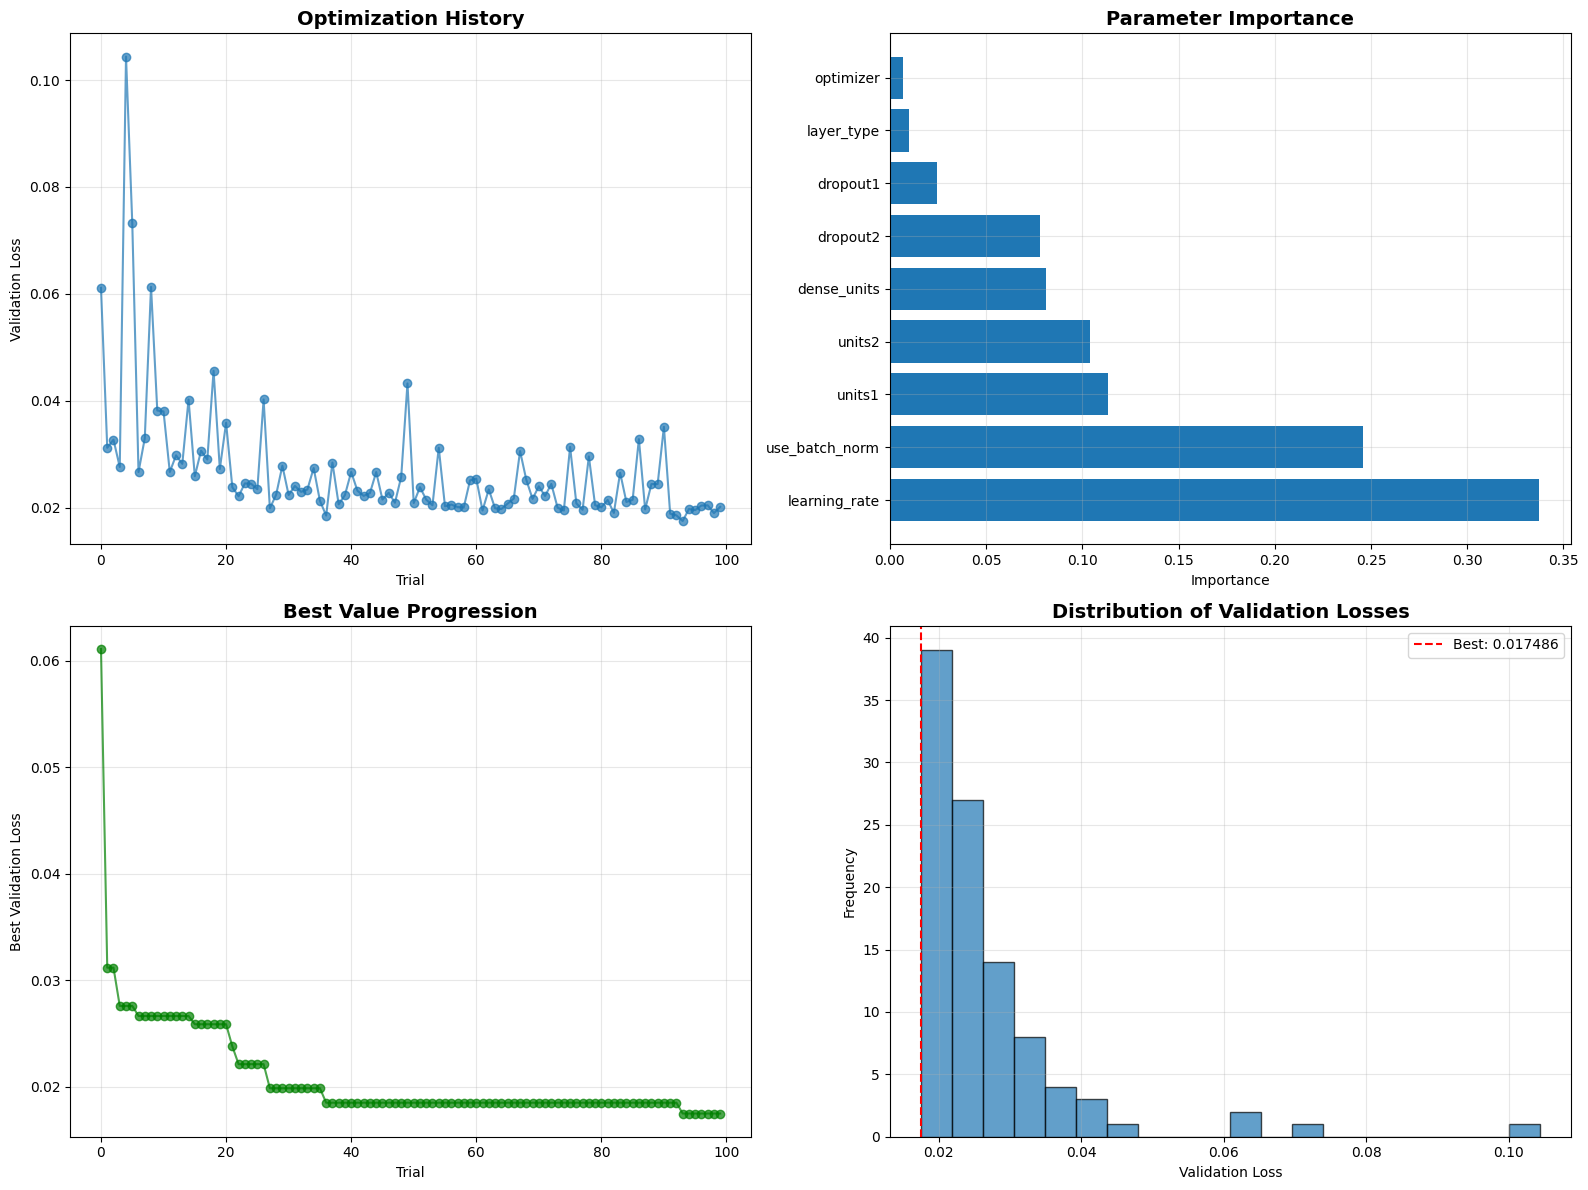


📊 Hyperparameter Tuning Results:
Best validation loss: 0.017486
Best parameters:
  units1: 256
  units2: 256
  dropout1: 0.1
  dropout2: 0.2
  dense_units: 16
  learning_rate: 0.0019149531362419314
  layer_type: GRU
  use_batch_norm: False
  optimizer: adam

Building final model with optimized parameters...

📋 Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 256)        │       230,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 629,281 (2.40 MB)

 Trainable params: 629,281 (2.40 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - loss: 0.1891 - mae: 0.3101 - val_loss: 0.0584 - val_mae: 0.1788 - learning_rate: 0.0019
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - loss: 0.0743 - mae: 0.1965 - val_loss: 0.0448 - val_mae: 0.1549 - learning_rate: 0.0019
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - loss: 0.0660 - mae: 0.1852 - val_loss: 0.0488 - val_mae: 0.1659 - learning_rate: 0.0019
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 0.0604 - mae: 0.1807 - val_loss: 0.0451 - val_mae: 0.1525 - learning_rate: 0.0019
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0494 - mae: 0.1585 - val_loss: 0.0358 - val_mae: 0.1376 - learning_rate: 0.0019
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 0.0443 - mae: 0.1555 - val_loss: 0.0427 - val_mae: 0.1499 - learning_rate: 0.0019
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - loss: 0.0405 - mae: 0.1470 - val_loss: 0.0362 - val_mae: 0

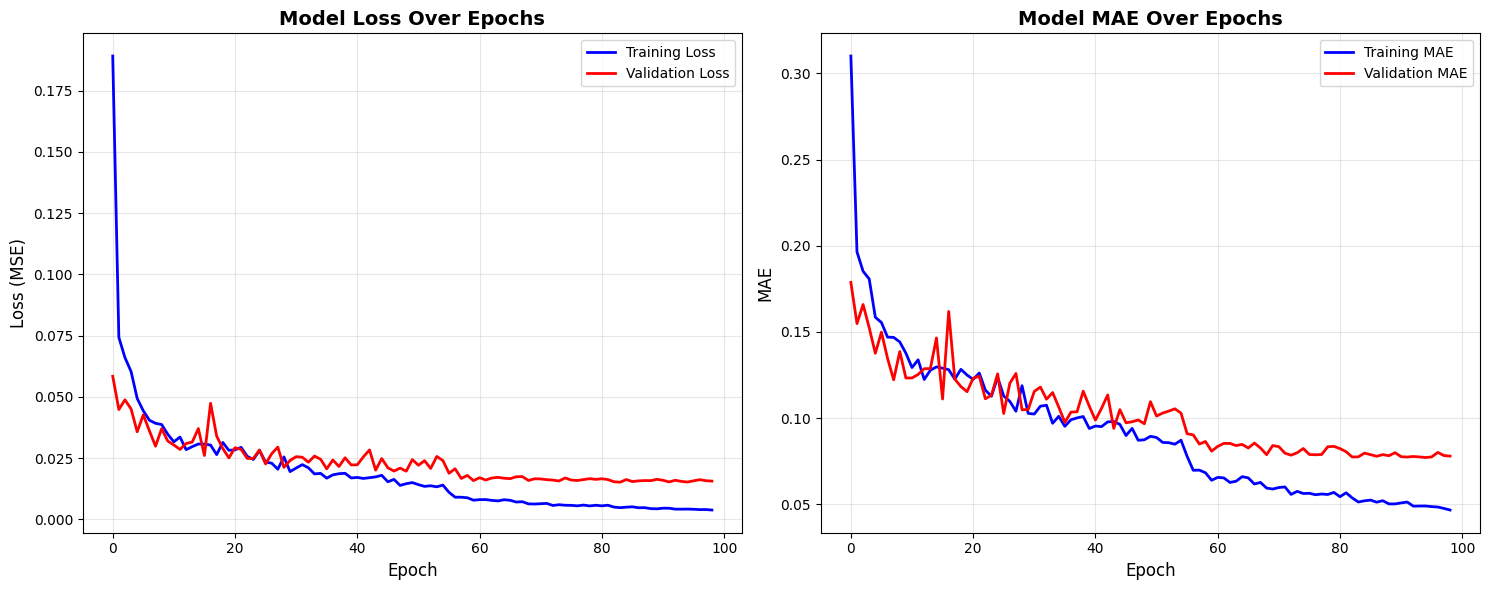


Final Training Metrics:
Training Loss: 0.0039
Validation Loss: 0.0157
Training MAE: 0.0467
Validation MAE: 0.0779

Evaluating final model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step

🎯 Final Model Performance on Test Set:
MAE: 66.55
RMSE: 104.52
R²: 0.9852

🎉 Model training completed!

📁 Saving model to: cinnamon_models\cinnamon_model_20250923_183211
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: cinnamon_models\cinnamon_model_20250923_183211

📊 Saved Model Summary:
  • Performance: MAE=66.55, RMSE=104.52, R²=0.9852
  • Hyperparameter tuning: optuna method used
  • Best parameters found and applied
  • Training epochs: 99
  • Total parameters: 629,281
Model saved at: cinnamon_models\cinnamon_model_20250923_183211
Available grades: ['alba' 'c4' 'c5' 'c5sp' 'h1' 'h2' 'h_faq']
Available regions: ['colombo' 'galle' 'hambantota' 'kalutara

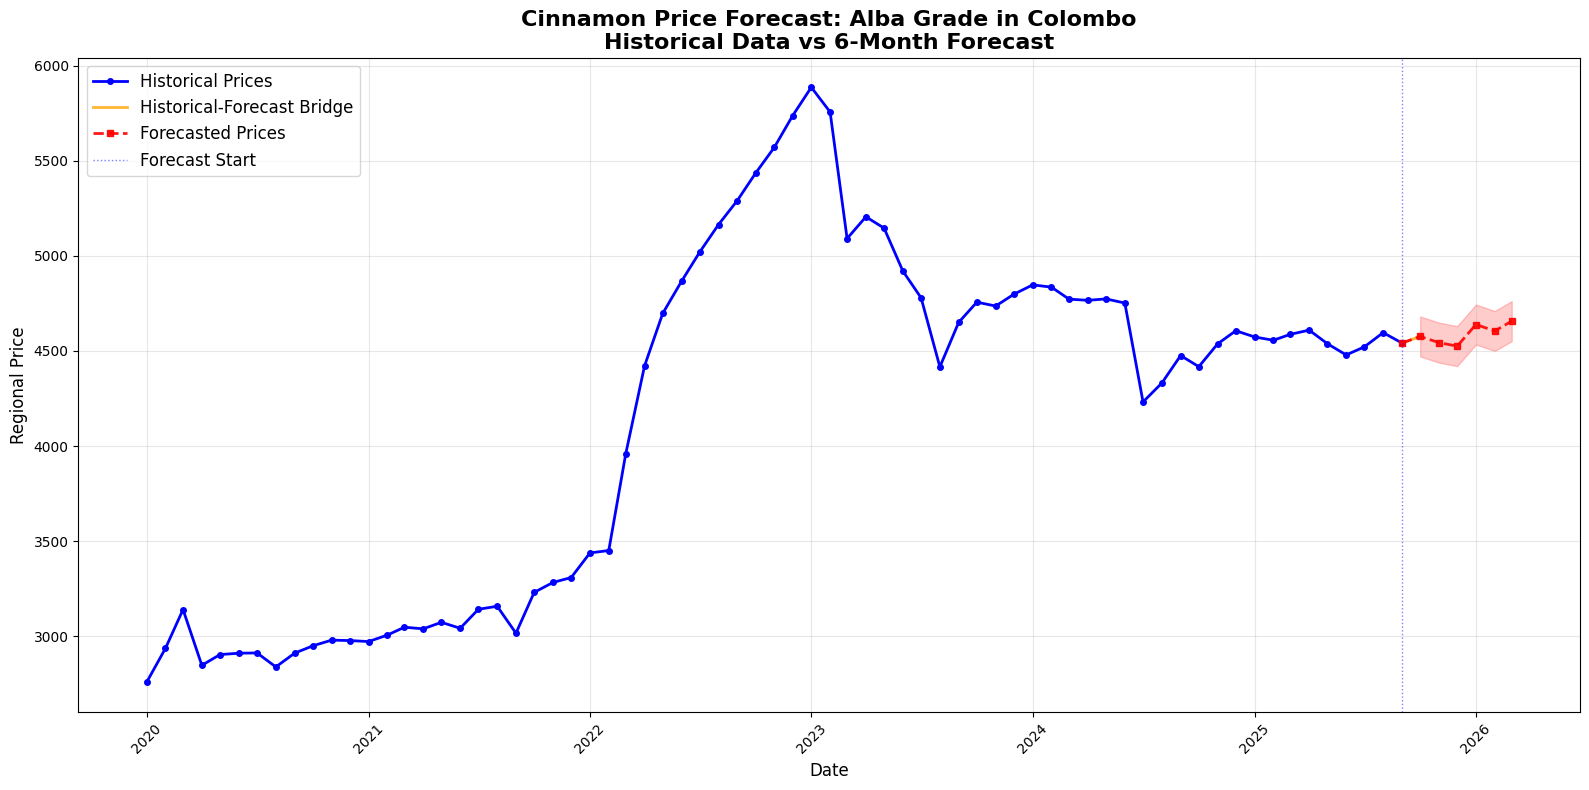


Alba Grade Forecast for Colombo:
Month  1 (2025-10): LKR. 4575.82
Month  2 (2025-11): LKR. 4543.52
Month  3 (2025-12): LKR. 4524.94
Month  4 (2026-01): LKR. 4638.70
Month  5 (2026-02): LKR. 4604.60
Month  6 (2026-03): LKR. 4656.51

Forecast Statistics:
Average Forecast Price: LKR.4590.68
Price Range: LKR.4524.94 - LKR.4656.51
Overall Trend: increasing by LKR.13.45 per month

📈 Generating forecast for c4 in galle...


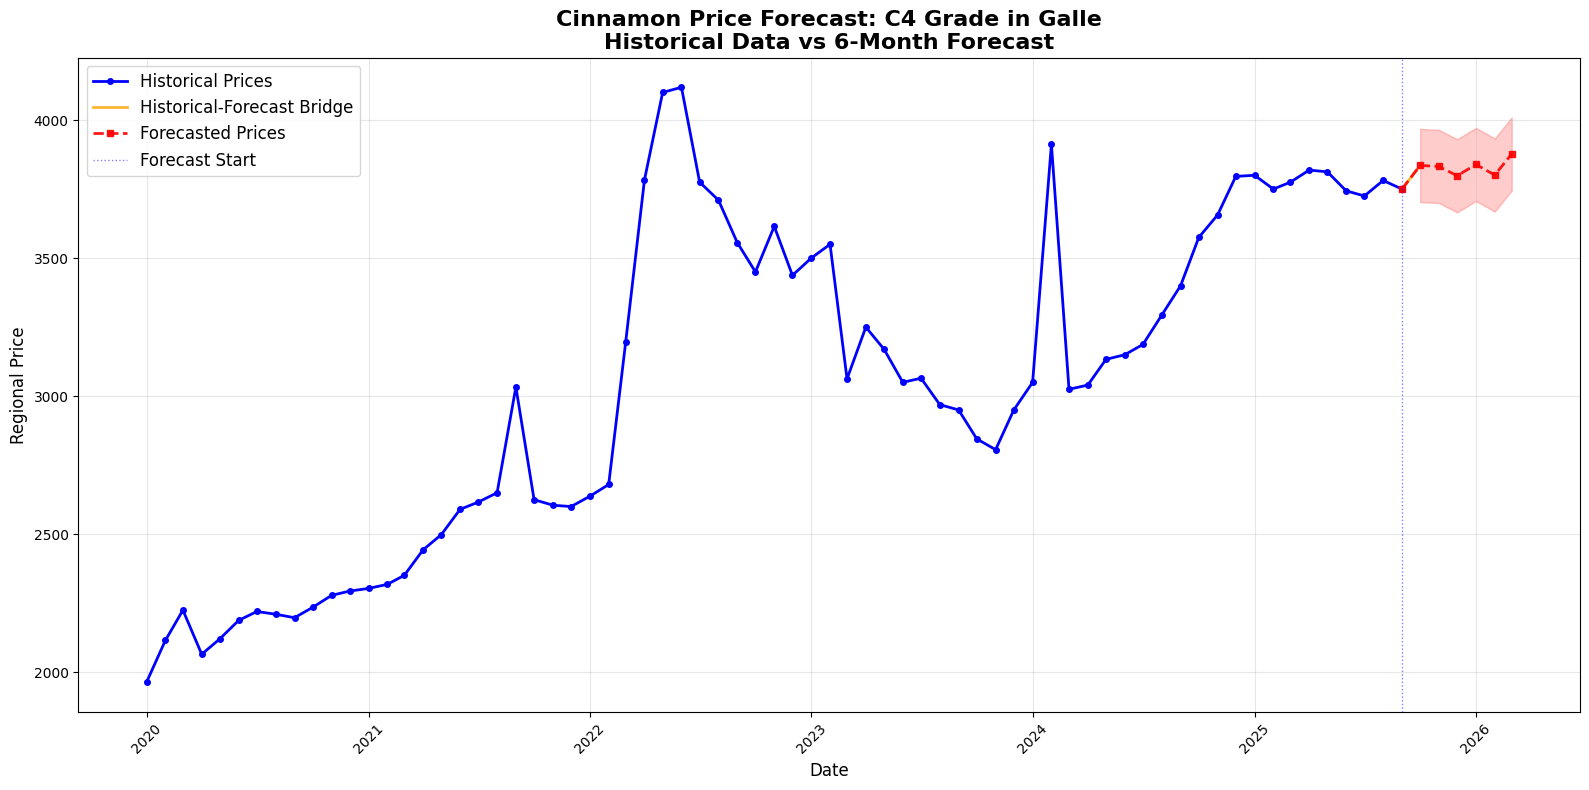


C4 Grade Forecast for Galle:
Month  1 (2025-10): LKR. 3835.61
Month  2 (2025-11): LKR. 3831.99
Month  3 (2025-12): LKR. 3798.24
Month  4 (2026-01): LKR. 3839.21
Month  5 (2026-02): LKR. 3800.85
Month  6 (2026-03): LKR. 3877.35

Forecast Statistics:
Average Forecast Price: LKR.3830.54
Price Range: LKR.3798.24 - LKR.3877.35
Overall Trend: increasing by LKR.6.96 per month

🔮 Interactive Forecast Generation

Available Grades:
1. alba
2. c4
3. c5
4. c5sp
5. h1
6. h2
7. h_faq

Available Regions:
1. colombo
2. galle
3. hambantota
4. kalutara
5. matara
6. ratnapura

📊 Generating 6-month forecast for alba in kalutara...


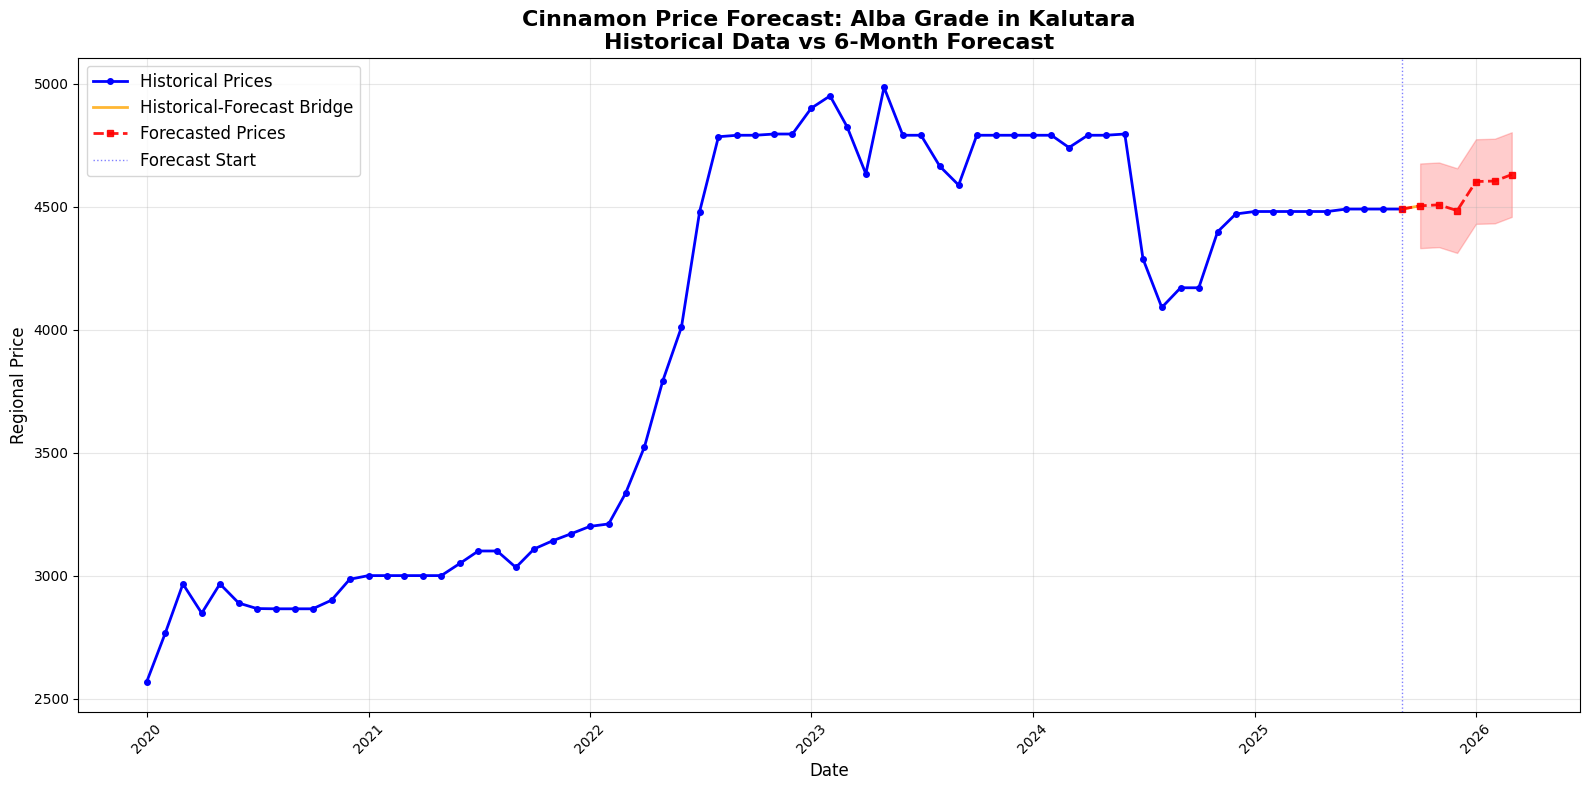


Alba Grade Forecast for Kalutara:
Month  1 (2025-10): LKR. 4503.12
Month  2 (2025-11): LKR. 4507.24
Month  3 (2025-12): LKR. 4483.72
Month  4 (2026-01): LKR. 4601.80
Month  5 (2026-02): LKR. 4603.82
Month  6 (2026-03): LKR. 4630.13

Forecast Statistics:
Average Forecast Price: LKR.4554.97
Price Range: LKR.4483.72 - LKR.4630.13
Overall Trend: increasing by LKR.21.17 per month

🎯 HYPERPARAMETER TUNING SUMMARY
✅ Hyperparameter tuning was performed using: optuna
🏆 Best parameters found:
   • units1: 256
   • units2: 256
   • dropout1: 0.1
   • dropout2: 0.2
   • dense_units: 16
   • learning_rate: 0.0019149531362419314
   • layer_type: GRU
   • use_batch_norm: False
   • optimizer: adam

📊 Final Model Performance:
   • MAE: 66.5547
   • RMSE: 104.5193
   • R²: 0.9852
   • Training epochs: 99

💡 To use different tuning methods, modify these variables:
   • USE_HYPERPARAMETER_TUNING = True/False
   • TUNING_METHOD = 'optuna'/'grid'/'random'
   • N_TUNING_TRIALS = number of trials


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

SEQUENCE_LENGTH = 12  # 12 months lookback
MODEL_DIR = 'cinnamon_models'

# Create model directory if it doesn't exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

def load_and_prepare_data(data_path):
    """Load and prepare the cinnamon price dataset"""
    # Load data
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    df.loc[df['Is_Active_Region'] == 0, 'Regional_Price'] = df.loc[df['Is_Active_Region'] == 0, 'National_Price']
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders:
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv'

df = load_and_prepare_data(DATA_PATH)
print("\nData loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head()

def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    plt.figure(figsize=(14, 8))
    
    # Remove rows with missing Regional_Price
    df_clean = df.dropna(subset=['Regional_Price'])
    
    # Create subplots for different visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Box plot of prices by grade
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Violin plot for detailed distribution
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Mean prices by grade with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 4. Histogram of all prices colored by grade
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))

plot_price_distribution_by_grade(df)

def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    # Select numeric features for correlation analysis
    numeric_features = [
        'Regional_Price', 'National_Price', 'Seasonal_Impact',
        'Local_Production_Volume', 'Local_Export_Volume',
        'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate',
        'Fuel_Price', 'Year', 'Month_num', 'Quarter', 'Grade_encoded',
        'Region_encoded', 'Is_Active_Region','GRN_QTY'
    ]
    
    # Filter to only include columns that exist in the dataframe
    available_features = [col for col in numeric_features if col in df.columns]
    
    # Calculate correlation matrix
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    # Create the plot
    plt.figure(figsize=(16, 14))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Cinnamon Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print highly correlated feature pairs
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

plot_feature_correlation_matrix(df)

def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
        'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Instead of dropping all NaNs, fill them
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print("Total sequences created:", len(X_sequences))
    return np.array(X_sequences), np.array(y_sequences), metadata

# ============ HYPERPARAMETER TUNING SECTION ============

def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model with various hyperparameters"""
    model = Sequential()
    
    # Choose layer type
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:  # SimpleRNN
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:  # SimpleRNN
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
        
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:  # SGD
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

class HyperparameterTuner:
    """Hyperparameter tuning class using multiple strategies"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def grid_search_tuning(self, param_grid=None, max_trials=20):
        """Grid search hyperparameter tuning"""
        print("\n🔍 Starting Grid Search Hyperparameter Tuning...")
        print("=" * 60)
        
        if param_grid is None:
            param_grid = {
                'units1': [64, 128, 256, 512, 1024],
                'units2': [32, 64, 128, 256, 512],
                'dropout1': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dropout2': [0.1, 0.2, 0.3, 0.4, 0.5],
                'dense_units': [16, 32, 64, 128, 256],
                'learning_rate': [0.001, 0.0005, 0.002, 0.005, 0.01],
                'layer_type': ['LSTM', 'GRU'],
                'use_batch_norm': [True, False]
            }
        
        # Generate all combinations and sample randomly if too many
        param_combinations = list(product(*param_grid.values()))
        if len(param_combinations) > max_trials:
            param_combinations = np.random.choice(
                param_combinations, size=max_trials, replace=False
            )
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        best_val_loss = float('inf')
        best_params = None
        
        for i, params in enumerate(param_combinations[:max_trials]):
            param_dict = dict(zip(param_grid.keys(), params))
            
            try:
                print(f"\nTrial {i+1}/{min(len(param_combinations), max_trials)}: {param_dict}")
                
                # Build and train model
                model = build_lstm_model_tunable(**param_dict, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': param_dict.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = param_dict.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Grid Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            # Define hyperparameter search space
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        # Create study and optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        # Plot optimization history
        self.plot_optuna_results(study)
        
        return study.best_params, study.best_value
    
    def plot_optuna_results(self, study):
        """Plot Optuna optimization results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot optimization history
        trials = study.trials
        values = [t.value for t in trials if t.value is not None]
        ax1.plot(values, marker='o', alpha=0.7)
        ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot parameter importance
        if len(study.trials) > 10:
            try:
                importance = optuna.importance.get_param_importances(study)
                params = list(importance.keys())
                importances = list(importance.values())
                
                ax2.barh(params, importances)
                ax2.set_title('Parameter Importance', fontsize=14, fontweight='bold')
                ax2.set_xlabel('Importance')
                ax2.grid(True, alpha=0.3)
            except:
                ax2.text(0.5, 0.5, 'Parameter importance\nnot available', 
                        ha='center', va='center', transform=ax2.transAxes)
        
        # Plot best value progression
        best_values = []
        current_best = float('inf')
        for trial in study.trials:
            if trial.value is not None and trial.value < current_best:
                current_best = trial.value
            best_values.append(current_best)
        
        ax3.plot(best_values, marker='o', alpha=0.7, color='green')
        ax3.set_title('Best Value Progression', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Trial')
        ax3.set_ylabel('Best Validation Loss')
        ax3.grid(True, alpha=0.3)
        
        # Distribution of validation losses
        ax4.hist(values, bins=20, alpha=0.7, edgecolor='black')
        ax4.axvline(study.best_value, color='red', linestyle='--', 
                   label=f'Best: {study.best_value:.6f}')
        ax4.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Validation Loss')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            # Randomly sample hyperparameters
            params = {
                'units1': np.random.choice([64, 128, 256, 512]),
                'units2': np.random.choice([32, 64, 128, 256]),
                'dropout1': np.random.uniform(0.1, 0.5),
                'dropout2': np.random.uniform(0.1, 0.5),
                'dense_units': np.random.choice([16, 32, 64, 128]),
                'learning_rate': np.random.loguniform(1e-4, 1e-2),
                'layer_type': np.random.choice(['LSTM', 'GRU']),
                'use_batch_norm': np.random.choice([True, False]),
                'optimizer': np.random.choice(['adam', 'rmsprop'])
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}: {params}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                # Clean up
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss
    
    def plot_tuning_results(self):
        """Plot hyperparameter tuning results"""
        if not self.tuning_results:
            print("No tuning results to plot.")
            return
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Extract data
        trials = [r['trial'] for r in self.tuning_results]
        val_losses = [r['val_loss'] for r in self.tuning_results]
        val_maes = [r['val_mae'] for r in self.tuning_results]
        
        # Plot validation loss progression
        ax1.plot(trials, val_losses, marker='o', alpha=0.7)
        ax1.set_title('Validation Loss by Trial', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Validation Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot validation MAE progression
        ax2.plot(trials, val_maes, marker='s', alpha=0.7, color='orange')
        ax2.set_title('Validation MAE by Trial', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Trial')
        ax2.set_ylabel('Validation MAE')
        ax2.grid(True, alpha=0.3)
        
        # Histogram of validation losses
        ax3.hist(val_losses, bins=15, alpha=0.7, edgecolor='black')
        ax3.axvline(self.best_score, color='red', linestyle='--', 
                   label=f'Best: {self.best_score:.6f}')
        ax3.set_title('Distribution of Validation Losses', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Validation Loss')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Best value progression
        best_so_far = []
        current_best = float('inf')
        for loss in val_losses:
            if loss < current_best:
                current_best = loss
            best_so_far.append(current_best)
        
        ax4.plot(trials, best_so_far, marker='o', alpha=0.7, color='green')
        ax4.set_title('Best Validation Loss Progression', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Trial')
        ax4.set_ylabel('Best Validation Loss')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna', 'grid', or 'random'")
    
    # Plot results
    if method in ['grid', 'random']:
        tuner.plot_tuning_results()
    
    return best_params, best_score, tuner

# ============ END HYPERPARAMETER TUNING SECTION ============

def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters from tuning"""
    if best_params is None:
        # Default parameters
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)

def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot training & validation MAE
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")

def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model with best parameters
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    # Print model summary
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    
    # Use longer training for final model
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    # Create comprehensive results dictionary
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    # Add tuning results if available
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results

# Train model with hyperparameter tuning
print("\n" + "="*80)
print("🚀 STARTING MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*80)

# You can change these parameters:
USE_HYPERPARAMETER_TUNING = True  # Set to False to skip tuning
TUNING_METHOD = 'optuna'  # Options: 'optuna', 'grid', 'random'
N_TUNING_TRIALS = 100  # Number of trials for tuning

model, history, metrics = train_model(
    df, 
    use_tuning=USE_HYPERPARAMETER_TUNING,
    tuning_method=TUNING_METHOD,
    n_tuning_trials=N_TUNING_TRIALS
)

print("\n🎉 Model training completed!")
print("="*80)

def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and all preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Create model-specific directory
    model_save_dir = os.path.join(model_dir, f"cinnamon_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n📁 Saving model to: {model_save_dir}")
    
    try:
        # 1. Save the Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # 2. Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # 3. Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # 4. Save model configuration and metadata (enhanced with tuning info)
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2']),
                'tuning_used': metrics.get('tuning_used', False),
                'tuning_method': metrics.get('tuning_method', None),
                'best_params': metrics.get('best_params', None),
                'epochs_trained': metrics.get('epochs_trained', 0),
                'final_train_loss': float(metrics.get('final_train_loss', 0)),
                'final_val_loss': float(metrics.get('final_val_loss', 0))
            }
        }
        
        # Save tuning results if available
        if 'tuning_results' in metrics and metrics['tuning_results']:
            tuning_results_path = os.path.join(model_save_dir, "tuning_results.json")
            with open(tuning_results_path, 'w') as f:
                json.dump(metrics['tuning_results'], f, indent=2, default=str)
            print(f"✅ Hyperparameter tuning results saved: tuning_results.json")
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        
        # Print summary of saved model
        print(f"\n📊 Saved Model Summary:")
        print(f"  • Performance: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
        if metrics.get('tuning_used'):
            print(f"  • Hyperparameter tuning: {metrics['tuning_method']} method used")
            print(f"  • Best parameters found and applied")
        print(f"  • Training epochs: {metrics.get('epochs_trained', 'N/A')}")
        print(f"  • Total parameters: {model.count_params():,}")
        
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('tuning_used'):
            print(f"🔧 This model was trained with {config['training_info']['tuning_method']} hyperparameter tuning")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None
    
saved_model_path=save_model(model, metrics)
print(f"Model saved at: {saved_model_path}")

# Define TRAIN_FEATURE_COLS globally when preparing training data
TRAIN_FEATURE_COLS = [
    'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
    'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Year', 'Month_num', 'Quarter',
    'Regional_Price_lag_1', 'Regional_Price_lag_3', 'Regional_Price_lag_6', 'Regional_Price_lag_12',
    'National_Price_lag_1', 'National_Price_lag_3', 'National_Price_lag_6', 'National_Price_lag_12',
    'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_6', 'Temperature_lag_12',
    'Rainfall_lag_1', 'Rainfall_lag_3', 'Rainfall_lag_6', 'Rainfall_lag_12',
    'Regional_Price_rolling_3', 'Regional_Price_rolling_6', 'Regional_Price_rolling_12',
    'Temperature_rolling_3', 'Temperature_rolling_6', 'Temperature_rolling_12',
    'Rainfall_rolling_3', 'Rainfall_rolling_6', 'Rainfall_rolling_12'
]

def forecast_prices(model, df, grade, region, months_ahead=12):
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')
    
    # Generate future rows
    future_rows = []
    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001,0.005))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002,0.02))
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag and rolling features
    for col in ['Regional_Price','National_Price','Temperature','Rainfall']:
        for lag in [1,3,6,12]:
            extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade','Region'])[col].shift(lag)
        for window in [3,6,12]:
            extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade','Region'])[col].transform(lambda x: x.rolling(window).mean())

    # Select exactly the features used during training
    feature_cols = [c for c in TRAIN_FEATURE_COLS if c in extended_df.columns]

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    for i in range(months_ahead):
        current_data = extended_df.iloc[len(historical_data)-SEQUENCE_LENGTH+i : len(historical_data)+i]
        if len(current_data) < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        sequence = current_data[feature_cols].ffill().bfill().values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        future_idx = len(historical_data)+i
        extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
        extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    return forecasts, future_dates

def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot 2: Historical data with forecast results"""
    try:
        # Get historical data for the specific grade and region
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"No data found for {grade} in {region}")
            return None, None
        
        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        # Create the plot
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # CREATE BRIDGE: Connect last historical point to first forecast
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        # Plot the connecting line (bridge)
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts (connected line)
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        # Add a vertical line to separate historical and forecasted data
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        # Customize the plot
        plt.title(f'Cinnamon Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis dates
        plt.xticks(rotation=45)
        
        # Add confidence bands (simplified approach using standard deviation)
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))  # Use last 12 months std
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std  # Exclude bridge point
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n{grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 50)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR.{price:8.2f}")
        
        print(f"\nForecast Statistics:")
        print(f"Average Forecast Price: LKR.{np.mean(forecasts):.2f}")
        print(f"Price Range: LKR.{np.min(forecasts):.2f} - LKR.{np.max(forecasts):.2f}")
        
        # Calculate trend
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            print(f"Overall Trend: {trend_direction} by LKR.{abs(trend):.2f} per month")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

available_grades = df['Grade'].unique()
available_regions = df['Region'].unique()

print(f"Available grades: {available_grades}")
print(f"Available regions: {available_regions}")

# Generate forecast for first combination
if len(available_grades) > 0 and len(available_regions) > 0:
    grade_to_forecast = available_grades[0]
    region_to_forecast = available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast} in {region_to_forecast}...")
    forecasts1, future_dates1 = plot_forecast_results(
        df, model, grade_to_forecast, region_to_forecast, months_ahead=6
    )

# Try another combination if available
if len(available_grades) > 1 and len(available_regions) > 1:
    grade_to_forecast2 = available_grades[1] if len(available_grades) > 1 else available_grades[0]
    region_to_forecast2 = available_regions[1] if len(available_regions) > 1 else available_regions[0]
    
    print(f"\n📈 Generating forecast for {grade_to_forecast2} in {region_to_forecast2}...")
    forecasts2, future_dates2 = plot_forecast_results(
        df, model, grade_to_forecast2, region_to_forecast2, months_ahead=6
    )

def interactive_forecast():
    """Allow user to select grade and region for forecasting"""
    print("\n🔮 Interactive Forecast Generation")
    print("=" * 50)
    
    # Display available options
    print("\nAvailable Grades:")
    for i, grade in enumerate(available_grades, 1):
        print(f"{i}. {grade}")
    
    print("\nAvailable Regions:")
    for i, region in enumerate(available_regions, 1):
        print(f"{i}. {region}")
    
    # Get user input
    try:
        grade_idx = int(input("\nSelect grade number: ")) - 1
        region_idx = int(input("Select region number: ")) - 1
        months = int(input("How many months to forecast (default 6): ") or "6")
        
        if 0 <= grade_idx < len(available_grades) and 0 <= region_idx < len(available_regions):
            selected_grade = available_grades[grade_idx]
            selected_region = available_regions[region_idx]
            
            print(f"\n📊 Generating {months}-month forecast for {selected_grade} in {selected_region}...")
            forecasts, dates = plot_forecast_results(
                df, model, selected_grade, selected_region, months_ahead=months
            )
            return forecasts, dates
        else:
            print("Invalid selection. Please try again.")
            return None, None
            
    except (ValueError, IndexError) as e:
        print(f"Error: {e}. Please enter valid numbers.")
        return None, None

interactive_forecast()

# ============ HYPERPARAMETER TUNING SUMMARY ============
print("\n" + "="*80)
print("🎯 HYPERPARAMETER TUNING SUMMARY")
print("="*80)

if metrics.get('tuning_used'):
    print(f"✅ Hyperparameter tuning was performed using: {metrics['tuning_method']}")
    print(f"🏆 Best parameters found:")
    for key, value in metrics['best_params'].items():
        print(f"   • {key}: {value}")
    print(f"\n📊 Final Model Performance:")
    print(f"   • MAE: {metrics['mae']:.4f}")
    print(f"   • RMSE: {metrics['rmse']:.4f}")
    print(f"   • R²: {metrics['r2']:.4f}")
    print(f"   • Training epochs: {metrics['epochs_trained']}")
else:
    print("❌ Hyperparameter tuning was skipped - default parameters used")

print("\n💡 To use different tuning methods, modify these variables:")
print("   • USE_HYPERPARAMETER_TUNING = True/False")
print("   • TUNING_METHOD = 'optuna'/'grid'/'random'")  
print("   • N_TUNING_TRIALS = number of trials")
print("="*80)